# Задача 9. Hand-crafted graph features

- Найти или сгенерировать набор данных для бинарной классификации графов.
- Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
    - Опишите графы с помощью вектора из количества кратчайших путей различной длины
    - Для вычисления длин кратчайших путей можно использовать nx.`shortest_path_length(G)`
    - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
    - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
    - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [105]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.metrics import classification_report
import random
import sklearn
from sklearn.svm import SVC
from networkx.generators import random_unlabeled_tree
import pandas as pd
from sklearn.metrics import f1_score
import seaborn as sns

In [86]:
DATASET_SIZE = 1200
NODES_NUMBER = 20
RANDOM_SEED = 16

## Данные

В качестве данных для классификации возьмем графы в виде обычных и сбалансированных деревьев

In [85]:
default_tree_graphs = [random_unlabeled_tree(NODES_NUMBER) for _ in range(int(DATASET_SIZE / 2))]
balanced_tree_graphs = [nx.balanced_tree(r=2, h=4)  for _ in range(int(DATASET_SIZE / 2))]

In [87]:
labels = [0] * len(balanced_tree_graphs) + [1] * len(default_tree_graphs)
graphs = balanced_tree_graphs + default_tree_graphs

train, test, y_train, y_test = sklearn.model_selection.train_test_split(graphs, labels, test_size=0.3, random_state=RANDOM_SEED, shuffle=True)

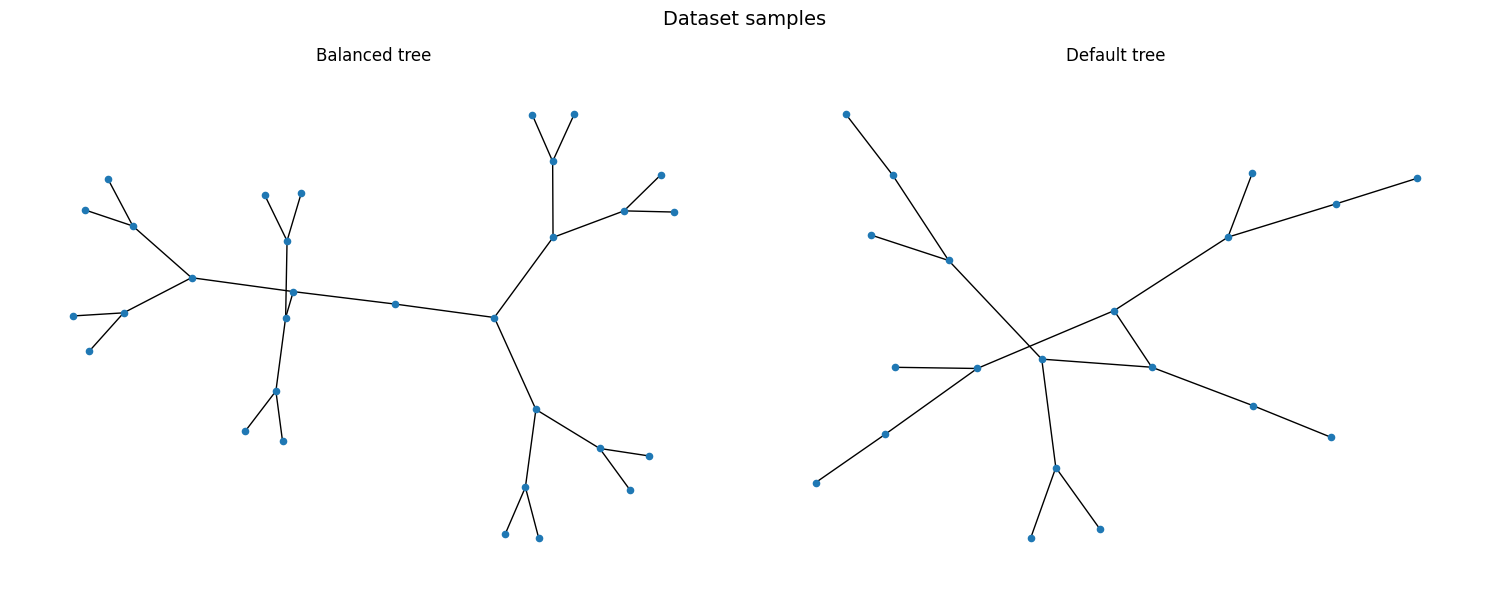

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

class0_idx = next(i for i, label in enumerate(y_train) if label == 0)
class1_idx = next(i for i, label in enumerate(y_train) if label == 1)

nx.draw(train[class0_idx], ax=axes[0], node_size=20, with_labels=False)
axes[0].set_title("Balanced tree", fontsize=12)

nx.draw(train[class1_idx], ax=axes[1], node_size=20, with_labels=False)
axes[1].set_title("Default tree", fontsize=12)

plt.suptitle("Dataset samples", fontsize=14)
plt.tight_layout()
plt.show()

## Shortest Path Kernel

In [114]:
def shortest_path_kernel(train_graphs, test_graphs, max_path_length=5, n_samples=10):

    def process_graph(graph):
        nodes = list(graph.nodes())
        phi = np.zeros(max_path_length)

        if len(nodes) < 2:
            return phi

        valid_samples = 0

        while valid_samples < n_samples:
            u, v = np.random.choice(nodes, 2, replace=False)

            try:
                path_length = nx.shortest_path_length(graph, u, v)
                idx = min(path_length, max_path_length-1)
                phi[idx] += 1
                valid_samples += 1
            except (nx.NetworkXNoPath, nx.NodeNotFound):
                pass

        return phi

    phi_train = np.array([process_graph(g) for g in train_graphs])
    phi_test = np.array([process_graph(g) for g in test_graphs])

    K_train = phi_train @ phi_train.T
    K_test = phi_test @ phi_train.T

    return K_train, K_test

## Обучение классификатора

In [115]:
K_train, K_test = shortest_path_kernel(train, test)

model = SVC(random_state=RANDOM_SEED).fit(K_train, y_train)
y_pred = model.predict(K_test)

In [116]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       182
           1       0.72      0.62      0.67       178

    accuracy                           0.69       360
   macro avg       0.69      0.69      0.69       360
weighted avg       0.69      0.69      0.69       360



Метрики уже хорошие! Подберем гиперпараметры, чтобы улучшить значения метрик

## Подбор гиперпараметров

In [117]:
MAX_PATH_LENGTHS = [1, 5, 10, 15, 20, 30]
SAMPLES_COUNT = [1, 10, 20, 30, 40, 50]

In [119]:
def search_best_params(max_paths, samples_counts, train_graphs, test_graphs):
    results = pd.DataFrame(columns=['max_path', 'samples', 'f1'])

    for max_path in max_paths:
        for samples_count in samples_counts:
            K_train, K_test = shortest_path_kernel(
                train_graphs,
                test_graphs,
                max_path_length=max_path,
                n_samples=samples_count
            )

            model = SVC(random_state=RANDOM_SEED)
            model.fit(K_train, y_train)
            y_pred = model.predict(K_test)

            current_f1 = f1_score(y_test, y_pred, average='weighted')

            results.loc[len(results)] = [max_path, samples_count, current_f1]

            print(f"Params: max_path={max_path}, samples={samples_count}")
            print(f"F1-score: {current_f1:.3f}\n")

    return results

results_df = search_best_params(MAX_PATH_LENGTHS, SAMPLES_COUNT, train, test)

Params: max_path=1, samples=1
F1-score: 0.327

Params: max_path=1, samples=10
F1-score: 0.327

Params: max_path=1, samples=20
F1-score: 0.327

Params: max_path=1, samples=30
F1-score: 0.327

Params: max_path=1, samples=40
F1-score: 0.327

Params: max_path=1, samples=50
F1-score: 0.327

Params: max_path=5, samples=1
F1-score: 0.532

Params: max_path=5, samples=10
F1-score: 0.682

Params: max_path=5, samples=20
F1-score: 0.731

Params: max_path=5, samples=30
F1-score: 0.814

Params: max_path=5, samples=40
F1-score: 0.838

Params: max_path=5, samples=50
F1-score: 0.847

Params: max_path=10, samples=1
F1-score: 0.590

Params: max_path=10, samples=10
F1-score: 0.804

Params: max_path=10, samples=20
F1-score: 0.850

Params: max_path=10, samples=30
F1-score: 0.933

Params: max_path=10, samples=40
F1-score: 0.942

Params: max_path=10, samples=50
F1-score: 0.961

Params: max_path=15, samples=1
F1-score: 0.571

Params: max_path=15, samples=10
F1-score: 0.780

Params: max_path=15, samples=20
F1-s

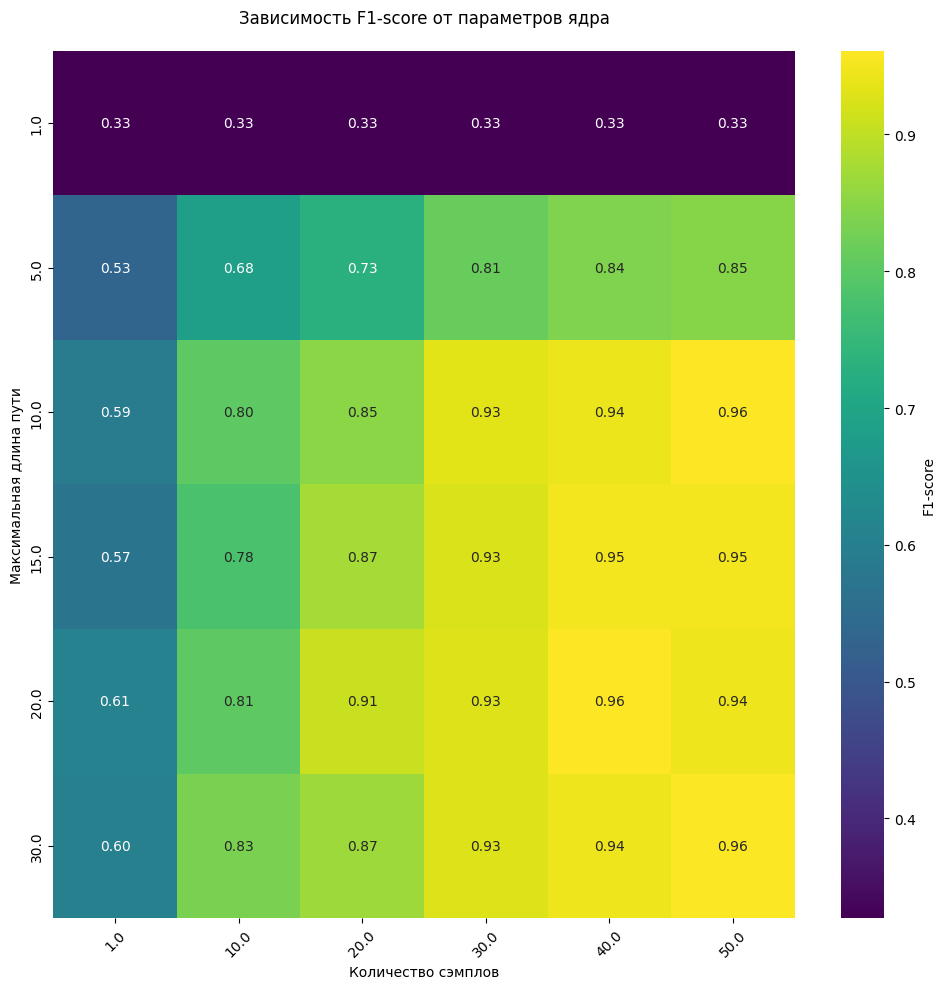

In [126]:
plt.figure(figsize=(10, 10))

heatmap_data = results_df.pivot(
    index='max_path',
    columns='samples',
    values='f1'
)

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={'label': 'F1-score'}
)

plt.title("Зависимость F1-score от параметров ядра", pad=20)
plt.xlabel("Количество сэмплов")
plt.ylabel("Максимальная длина пути")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Weisfeiler-Lehman Kernel

In [133]:
def _initialize_node_colors(graph):
    return {node: 1 for node in graph.nodes}

def _compute_neighbor_features(
    graph,
    node_colors,
    neighbor_cache
):
    features = {}
    for node in graph.nodes:
        neighbor_colors = tuple(sorted(node_colors[n] for n in neighbor_cache[node]))
        features[node] = (node_colors[node], neighbor_colors)
    return features

def _update_color_mapping(
    feature_groups,
    color_memo,
    unique_color_counter,
    limit,
):
    new_colors = {}
    for features, nodes in feature_groups.items():
        if features not in color_memo:
            color_memo[features] = unique_color_counter
            unique_color_counter += 1

        mapped_color = color_memo[features] % limit
        for node in nodes:
            new_colors[node] = mapped_color
    return new_colors, unique_color_counter

def wl_kernel_helper(
    graph: nx.Graph,
    iterations = 5,
    limit = 1000
):
    node_colors = _initialize_node_colors(graph)
    neighbor_cache = {node: list(nx.neighbors(graph, node)) for node in graph.nodes}
    color_memo = {}
    unique_color_counter = 2

    for _ in range(iterations):
        neighbor_features = _compute_neighbor_features(graph, node_colors, neighbor_cache)

        feature_groups = defaultdict(list)
        for node, features in neighbor_features.items():
            feature_groups[features].append(node)

        node_colors, unique_color_counter = _update_color_mapping(
            feature_groups,
            color_memo,
            unique_color_counter,
            limit
        )

    histogram = np.zeros(limit, dtype=np.int32)
    for color in node_colors.values():
        histogram[color] += 1

    return histogram / histogram.sum()

def wl_kernel(
    train_graphs,
    test_graphs,
    iterations = 5,
    limit = 1000
):
    if not train_graphs or not test_graphs:
        raise ValueError("Input graphs lists cannot be empty")

    phi_train = np.array([wl_kernel_helper(g, iterations, limit) for g in train_graphs])
    phi_test = np.array([wl_kernel_helper(g, iterations, limit) for g in test_graphs])

    K_train = phi_train @ phi_train.T
    K_test = phi_test @ phi_train.T

    return K_train, K_test

In [134]:
K_train_gk, K_test_gk = wl_kernel(train, test)
model = SVC(random_state=RANDOM_SEED)

model.fit(K_train_gk, y_train)
y_pred = model.predict(K_test_gk)

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00       178

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



Благодаря методу Weisfeiler-Lehman смогли достичь метрику, достигающую значение 1.0

## Итого

- [x] Найти или сгенерировать набор данных для бинарной классификации графов.
- [x] Реализовать функцию shortest_path_kernel(train_graphs, test_graphs), которая принимает тренировочный и тестовые наборы, а возвращает пару K_train, K_test
    - Опишите графы с помощью вектора из количества кратчайших путей различной длины
    - Для вычисления длин кратчайших путей можно использовать nx.`shortest_path_length(G)`
    - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
    - K_train - матрица из ядровых функций для сравнения тренировочных графов между собой
    - K_test - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- [x] Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- [x] (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.